# Pytorch

In this notebook we will learn how to train a neural network with [pytorch](https://pytorch.org/docs/stable/index.html), a great Python library for Deep Learning.

As an example, we want to learn the following mysterious function:

In [28]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def mysterious_function(x):
    return torch.sin(x)

Here is a small function to generate a batch of size ``num_samples``:

In [29]:
def getdata(num_samples):
    x = torch.randn(num_samples,1)
    y = mysterious_function(x)
    return x, y

x, y = getdata(10)
print(x)
print(y)

tensor([[-1.0591],
        [-2.1062],
        [ 1.1026],
        [-0.2818],
        [ 0.7492],
        [ 0.9803],
        [-1.0115],
        [-0.2054],
        [ 1.9333],
        [-0.8107]])
tensor([[-0.8719],
        [-0.8601],
        [ 0.8924],
        [-0.2781],
        [ 0.6811],
        [ 0.8306],
        [-0.8476],
        [-0.2039],
        [ 0.9350],
        [-0.7248]])


**Remark**: The variables x and y in this function have the data type ``torch.Tensor``. Tensors are in most aspects very similar to numpy arrays, but they can also store gradients. More on this later.

Next we define the class with our neural network. This class should always inherit ``nn.Module`` (the base class for all neural networks) and has to define the two functions ``__init__`` and ``forward``.

The net we are using here contains one linear layer with 1 input and 20 output nodes, followed by a ReLU layer and finally another linear layer with 20 input nodes and 1 output node. We use ``add_module`` to add these layers to our net with the first parameter being the name of the layer added.

The ``forward`` function describes the forward pass through the network. In our case we just call the layers defined in ``__init__`` in the right order.

(**Tip**: In this case we could also have saved the definition of the class and instead used ``nn.Sequential``, but we do it anyways for educational purposes.)

In [30]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.add_module('hidden', nn.Linear(1, 20))
        self.add_module('relu', nn.ReLU())
        self.add_module('out', nn.Linear(20,1))

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.out(x)
        return x

Now comes the heart of our little program - the training loop.
For this we first need to choose an optimizing strategy and a loss function (here SGD and L1).
And this is what it looks like:

In [31]:
def train(num_steps, learning_rate, batch_size):
    model = MyNet()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    loss_fn = nn.L1Loss()
    model.train()

    for step in range(num_steps):
        optimizer.zero_grad()
        x, y = getdata(batch_size)
        y_model = model(x)
        loss = loss_fn(y_model, y)
        loss.backward()
        optimizer.step()

    return model

Ok, let us go through this part step by step:

First we pick an optimization strategy and a loss function (here SGD and L1). Here, ``model.parameters()`` returns an iterator over all parameters of ``model``. (By the way, this is why we used ``add_module`` instead of ``self.hidden = ...`` etc. earlier.)

``optimizer.zero_grad()`` initializes all gradients of all parameters to zero.

``model(x)`` calls the ``forward`` function of ``model`` and at the same time builds the computation graph dynamically.

``loss.backward()`` then iterates backwards through the computation graph and computes the gradients (which are stored in the model parameters).

And finally ``optimizer.step()`` executes one learning step with the current gradients.

We can now set our hyperparameters and call our training function.
We also added a small test output for good measure.

In [32]:
num_steps = 100
learning_rate = 0.01
batch_size = 256

model = train(num_steps, learning_rate, batch_size)

model.eval()
x, y = getdata(100)
y_model = model(x)
for i in range(100):
    print('mysterious_function({}) = {}, but MyNet says {} which is wrong by {}.'.format(
        float(x[i]),
        float(y[i]),
        float(y_model[i]),
        float((y[i] - y_model[i]).abs())
        ))
print('Average loss is {}.'.format(float((y - y_model).abs().mean())))

mysterious_function(0.004012155346572399) = 0.004012144636362791, but MyNet says 0.004558369517326355 which is wrong by 0.0005462248809635639.
mysterious_function(-1.7305198907852173) = -0.9872713088989258, but MyNet says -1.3503772020339966 which is wrong by 0.3631058931350708.
mysterious_function(-0.16586999595165253) = -0.16511045396327972, but MyNet says -0.13997069001197815 which is wrong by 0.025139763951301575.
mysterious_function(-0.6521392464637756) = -0.6068880558013916, but MyNet says -0.5288702249526978 which is wrong by 0.07801783084869385.
mysterious_function(-0.2710886597633362) = -0.26778051257133484, but MyNet says -0.2294866144657135 which is wrong by 0.03829389810562134.
mysterious_function(-0.09438181668519974) = -0.09424175322055817, but MyNet says -0.07915136218070984 which is wrong by 0.015090391039848328.
mysterious_function(0.2886490523815155) = 0.28465741872787476, but MyNet says 0.25995349884033203 which is wrong by 0.024703919887542725.
mysterious_function(0

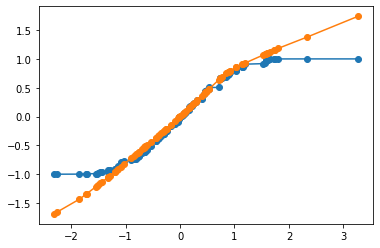

In [33]:
data = torch.cat([x, y, y_model], dim = 1).detach().numpy()
data.sort(0)
data = data.T
plt.plot(data[0], data[1], '-o', label='data')
plt.plot(data[0], data[2], '-o', label='prediction')
plt.show()